In [1]:
import pandas as pd

In [2]:
bioassay = pd.read_csv('../AID_1706_datatable_all.csv.gz',compression='gzip',skiprows=range(1,5))

In [4]:
# Get what is usefull, and rename to match VS naming scheme
df = bioassay[['PUBCHEM_SID','PUBCHEM_ACTIVITY_OUTCOME','Inhibition']]
df.columns=['id','kind','Inhibition']

In [10]:
# Read qvina docking scores, and fix wrong HEADER
qvina = pd.read_csv('DockFlow_qvina.csv.gz',compression='gzip')
qvina.columns=['id','pose','qvina']

# Read Rescores.
vina    = pd.read_csv('rescore_vina.csv.gz',compression='gzip')
smina   = pd.read_csv('rescore_smina.csv.gz',compression='gzip')
vinardo = pd.read_csv('rescore_vinardo.csv.gz',compression='gzip')

# Read RF-ScoreVS_v2 rescore
rfscore_vs_v2 = pd.read_csv('rfscore.csv.gz',compression='gzip')
rfscore_vs_v2.columns=['pose','id','RFScoreVS_v2']

/home/caio/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (0,1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
# Concatenate all into "data"
data = pd.merge(df,rfscore_vs_v2,on='id')
data = pd.merge(data,qvina,  on=['id','pose'])
data = pd.merge(data,vina,   on=['id','pose'])
data = pd.merge(data,smina,  on=['id','pose'])
data = pd.merge(data,vinardo,on=['id','pose'])

In [15]:
data

,id,kind,Inhibition,pose,RFScoreVS_v2,qvina,vina,smina,vinardo
0,842121,Inactive,-1.55,1,5.950024,-5.6,-5.6348,-5.84857,-6.46782
1,842121,Inactive,-1.55,2,5.959857,-5.6,-4.91094,-5.04426,-5.03265
2,842121,Inactive,-1.55,3,5.962348,-5.5,-5.13135,-5.26157,-5.79712
3,842121,Inactive,-1.55,4,5.966875,-5.4,-5.27989,-5.44041,-6.66113
4,842121,Inactive,-1.55,5,5.973818,-5.4,-5.45266,-5.5867,-5.88591
...,...,...,...,...,...,...,...,...,...
547816,51090821,Inactive,0.19,6,5.955770,-6.2,-6.29844,-6.65426,-6.4851
547817,51090821,Inactive,0.19,7,5.955254,-5.5,-5.81293,-5.85161,-5.68095
547818,51090821,Inactive,0.19,8,5.964141,-5.3,-5.89117,-6.02238,-6.47135
547819,51090821,Inactive,0.19,9,5.951377,-5.3,-5.41285,-6.16561,-6.31044


qvina: 0.405325
vina: 0.402754
smina: 0.401393
vinardo: 0.405618
RFScoreVS_v2: 0.531481


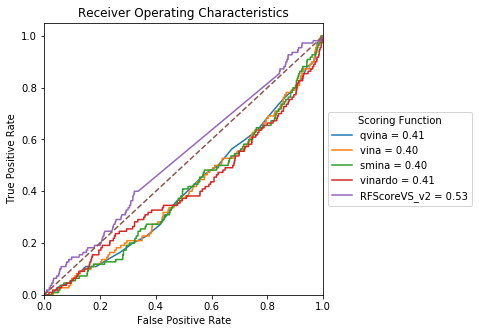

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5))
for SF in ['qvina','vina','smina','vinardo','RFScoreVS_v2']:
    # 1st top pose according to each scoring function
    df = data.sort_values(SF).groupby('id').head(1)
    fpr, tpr, _ = roc_curve(df['kind'].to_numpy(), df[SF].to_numpy(), pos_label='Active')
    roc_auc = auc(fpr, tpr)
    print(f'{SF}: {roc_auc:>.6f}')
    ax.plot(fpr, tpr, label=f'{SF} = {roc_auc:>.2f}')

# Plot a line
ax.plot([0,1], [0,1], linestyle='--')

# Some legends
ax.set(xlim=[0.0,1.0], ylim=[0.0,1.05], xlabel='False Positive Rate', ylabel='True Positive Rate', title='Receiver Operating Characteristics')
plt.legend(title='Scoring Function', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

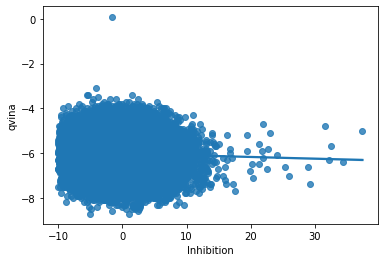

In [39]:
# Só de curiosidade, como está a correlação com a inibição (não espere ser boa... tá um lixo.)

# 1st top pose according to Qvina
df = data.sort_values('qvina').groupby('id').head(1)
sns.regplot(data=df.query('-10 < Inhibition < 40'),x='Inhibition',y='qvina',label=f'QVINA')